# Question 3

Train on MNIST dataset using an MLP. The original training dataset contains 60,000 images and the test contains 10,000 images. If you are short on compute, use a stratified subset of a smaller number of images. But, the test set remains the same 10,000 images. Compare against RF and Logistic Regression models.  The metrics can be: F1-score, confusion matrix. What do you observe? What all digits are commonly confused? 

Let us assume your MLP has 30 neurons in the first layer, 20 in the second layer and then 10 finally for the output layer (corresponding to 10 classes). On the trained MLP, plot the t-SNE for the output from the layer containing 20 neurons for the 10 digits. Contrast this with the t-SNE for the same layer but for an untrained model. What do you conclude? 

Now, use the trained MLP to predict on the Fashion-MNIST dataset. What do you observe? How do the embeddings (t-SNE viz for the second layer compare for MNIST and Fashion-MNIST images) [3 marks]


In [1]:
import numpy as np
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.manifold import TSNE
import seaborn as sns

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train_flat = x_train.reshape(-1, 28 * 28)
x_test_flat = x_test.reshape(-1, 28 * 28)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
X_train_t = torch.tensor(x_train_flat).to(device)
Y_train_t = torch.tensor(y_train).to(device)
X_test_t = torch.tensor(x_test_flat).to(device)
Y_test_t = torch.tensor(y_test).to(device)

print(device)
print("Training set shape:", x_train_flat.shape)
print("Test set shape:", x_test_flat.shape)

cuda
Training set shape: (60000, 784)
Test set shape: (10000, 784)


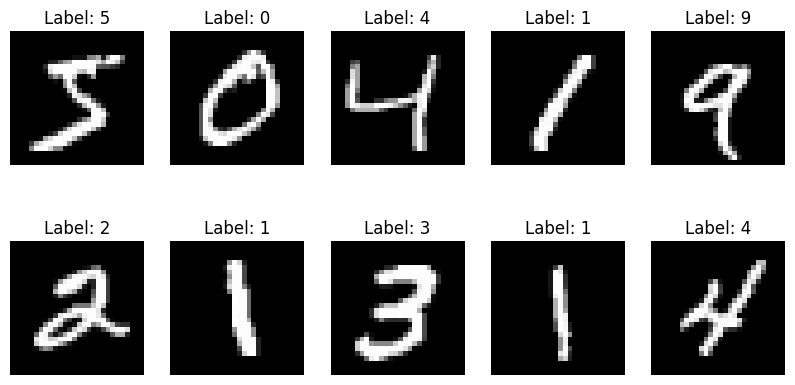

In [3]:
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.show()

In [6]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(28*28, 30)
        self.hidden2 = nn.Linear(30, 20)
        self.output = nn.Linear(20, 10)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = self.output(x)
        return x

model = MLP().to(device)
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 100
batch_size = 64

for epoch in range(epochs):
    model.train()
    for i in range(0, len(X_train_t), batch_size):
        x_batch = X_train_t[i:i + batch_size]
        y_batch = Y_train_t[i:i + batch_size]

        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_t)
    y_test_pred_classes = torch.argmax(y_test_pred, dim=1)

f1_mlp = f1_score(Y_test_t.cpu(), y_test_pred_classes.cpu(), average='macro')
conf_matrix_mlp = confusion_matrix(Y_test_t.cpu(), y_test_pred_classes.cpu())

print(f"MLP F1 Score: {f1_mlp:.4f}")
print("MLP Confusion Matrix:")
print(conf_matrix_mlp)
print("MLP Classification Report:")
print(classification_report(Y_test_t.cpu(), y_test_pred_classes.cpu(), target_names=[str(i) for i in range(10)]))


MLP F1 Score: 0.9628
MLP Confusion Matrix:
[[ 965    0    1    1    0    7    2    2    2    0]
 [   0 1124    2    1    0    0    2    1    5    0]
 [   6    8  978   14    4    1    3    6   11    1]
 [   1    0    2  979    0   15    1    3    4    5]
 [   1    1    3    1  957    3    5    3    1    7]
 [   5    2    1   13    3  860    4    0    4    0]
 [   5    3    5    1    5   16  920    1    2    0]
 [   1    7   10    2    3    1    0  989    4   11]
 [   3    5    3   19    4   12    3    3  911   11]
 [   5    6    1    8   23    8    0    6    3  949]]
MLP Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.97      0.99      0.98      1135
           2       0.97      0.95      0.96      1032
           3       0.94      0.97      0.96      1010
           4       0.96      0.97      0.97       982
           5       0.93      0.96      0.95       892
           6       0

In [7]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train_flat, y_train)

y_pred_rf = rf_model.predict(x_test_flat)

f1_rf = f1_score(y_test, y_pred_rf, average='macro')
print(f"Random Forest F1 Score: {f1_rf:.4f}")

conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("Random Forest Confusion Matrix:")
print(conf_matrix_rf)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=[str(i) for i in range(10)]))

Random Forest F1 Score: 0.9702
Random Forest Confusion Matrix:
[[ 971    0    0    0    0    2    3    1    3    0]
 [   0 1127    2    2    0    1    2    0    1    0]
 [   6    0 1002    5    3    0    3    8    5    0]
 [   1    0    9  972    0    9    0    9    8    2]
 [   1    0    0    0  955    0    5    1    4   16]
 [   5    1    1    9    2  860    5    2    5    2]
 [   7    3    0    0    3    3  937    0    5    0]
 [   1    4   20    2    0    0    0  989    2   10]
 [   4    0    6    7    5    5    5    4  930    8]
 [   7    6    2   12   12    1    0    4    4  961]]
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.97      1032
           3       0.96      0.96      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.98      0.96      0.97 

In [8]:
lr_model = LogisticRegression(max_iter=500, solver='lbfgs')
lr_model.fit(x_train_flat, y_train)

y_pred_lr = lr_model.predict(x_test_flat)

f1_lr = f1_score(y_test, y_pred_lr, average='macro')
print(f"Logistic Regression F1 Score: {f1_lr:.4f}")

conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
print("Logistic Regression Confusion Matrix:")
print(conf_matrix_lr)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr, target_names=[str(i) for i in range(10)]))

Logistic Regression F1 Score: 0.9249
Logistic Regression Confusion Matrix:
[[ 957    0    1    4    1    9    4    3    1    0]
 [   0 1111    4    2    0    2    3    2   11    0]
 [   6    9  930   16   10    3   12   10   32    4]
 [   4    1   17  921    1   25    2   10   20    9]
 [   1    3    7    3  921    0    7    4    6   30]
 [   9    2    3   34    8  780   15    7   30    4]
 [   8    3    8    2    7   17  910    2    1    0]
 [   1    7   24    6    6    1    0  948    3   32]
 [  10   11    6   22    8   28   13    9  855   12]
 [   9    8    1    9   21    7    0   20    7  927]]
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.90      0.91      0.91      1010
           4       0.94      0.94      0.94       982
           5       0.89   

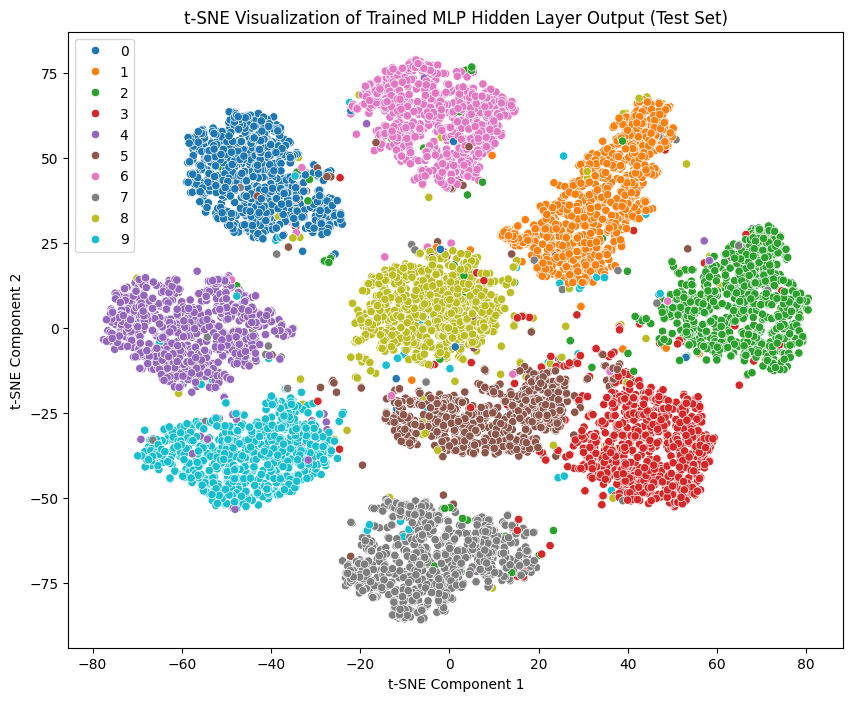

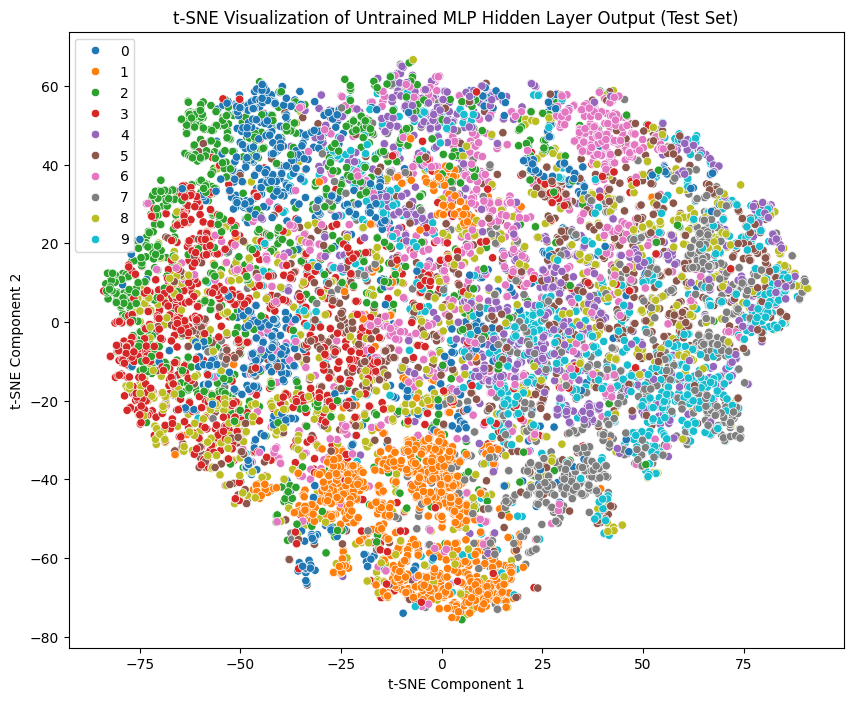

In [9]:
# t-SNE visualization for the trained MLP
model.eval()
with torch.no_grad():
    hidden_layer_output_trained = torch.relu(model.hidden2(torch.relu(model.hidden1(X_test_t))))

hidden_layer_output_trained = hidden_layer_output_trained.cpu().numpy()
tsne_trained = TSNE(n_components=2, random_state=42)
hidden_layer_tsne_trained = tsne_trained.fit_transform(hidden_layer_output_trained)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=hidden_layer_tsne_trained[:, 0], y=hidden_layer_tsne_trained[:, 1], hue=y_test, palette='tab10', legend='full')
plt.title('t-SNE Visualization of Trained MLP Hidden Layer Output (Test Set)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

# t-SNE visualization for the untrained MLP
untrained_model = MLP().to(device)

with torch.no_grad():
    hidden_layer_output_untrained = torch.relu(untrained_model.hidden2(torch.relu(untrained_model.hidden1(X_test_t))))

hidden_layer_output_untrained = hidden_layer_output_untrained.cpu().numpy()
hidden_layer_tsne_untrained = tsne_trained.fit_transform(hidden_layer_output_untrained)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=hidden_layer_tsne_untrained[:, 0], y=hidden_layer_tsne_untrained[:, 1], hue=y_test, palette='tab10', legend='full')
plt.title('t-SNE Visualization of Untrained MLP Hidden Layer Output (Test Set)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


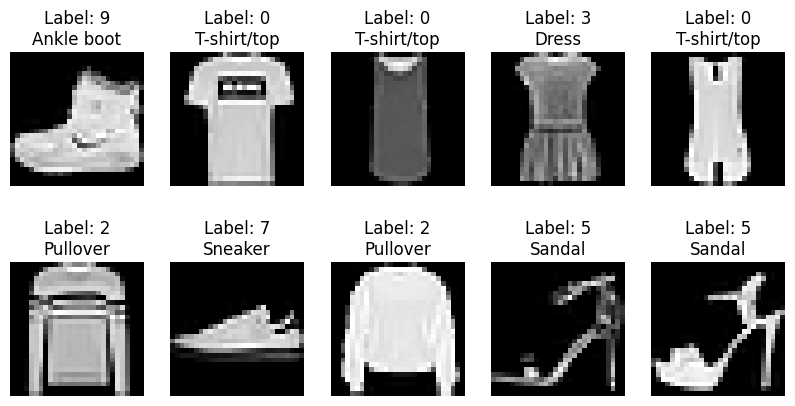

True Labels and Predicted Labels for the Fashion-MNIST Test Set:
True Label: 9, Predicted Label: 2 (Pullover)
True Label: 2, Predicted Label: 6 (Shirt)
True Label: 1, Predicted Label: 5 (Sandal)
True Label: 1, Predicted Label: 5 (Sandal)
True Label: 6, Predicted Label: 5 (Sandal)
True Label: 1, Predicted Label: 5 (Sandal)
True Label: 4, Predicted Label: 2 (Pullover)
True Label: 6, Predicted Label: 5 (Sandal)
True Label: 5, Predicted Label: 4 (Coat)
True Label: 7, Predicted Label: 2 (Pullover)
MLP F1 Score: 0.0466
MLP Confusion Matrix:
[[ 23   8  42  59   4 775  46  22   3  18]
 [ 56   2 154  46   0 731   6   0   3   2]
 [115   1 100  12   0 303 461   1   5   2]
 [ 68   0  58 146   0 688  12  10   3  15]
 [269   1 137  35   0 345 195   0  12   6]
 [  8  37 747  10  62 100  11  16   8   1]
 [162   6  75  36   3 552 119  16   7  24]
 [  0   0 976   0   2  16   1   5   0   0]
 [ 10   4 491  18   7 156  13 146   1 154]
 [  0  28 870   7   0  81   5   3   6   0]]
MLP Classification Report:
 

In [14]:
(fashion_x_train, fashion_y_train), (fashion_x_test, fashion_y_test) = tf.keras.datasets.fashion_mnist.load_data()

fashion_labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
                  "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(fashion_x_train[i], cmap='gray')  
    numeric_label = fashion_y_train[i]  
    human_readable_label = fashion_labels[numeric_label] 
    plt.title(f"Label: {numeric_label}\n{human_readable_label}")  
    plt.axis('off')
plt.show()

fashion_x_train = fashion_x_train.astype('float32') / 255.0
fashion_x_test = fashion_x_test.astype('float32') / 255.0

fashion_x_train_flat = fashion_x_train.reshape(-1, 28 * 28)
fashion_x_test_flat = fashion_x_test.reshape(-1, 28 * 28)

fashion_X_test_t = torch.tensor(fashion_x_test_flat).to(device)
fashion_Y_test_t = torch.tensor(fashion_y_test).to(device)

model.eval()
with torch.no_grad():
    y_test_pred = model(fashion_X_test_t)
    y_test_pred_classes = torch.argmax(y_test_pred, dim=1)

f1_mlp = f1_score(fashion_Y_test_t.cpu(), y_test_pred_classes.cpu(), average='macro')
conf_matrix_mlp = confusion_matrix(fashion_Y_test_t.cpu(), y_test_pred_classes.cpu())

print("True Labels and Predicted Labels for the Fashion-MNIST Test Set:")
for i in range(10):  
    true_label = fashion_y_test[i]
    predicted_label = y_test_pred_classes[i].item()  
    print(f"True Label: {true_label}, Predicted Label: {predicted_label} ({fashion_labels[predicted_label]})")


print(f"MLP F1 Score: {f1_mlp:.4f}")
print("MLP Confusion Matrix:")
print(conf_matrix_mlp)
print("MLP Classification Report:")
print(classification_report(fashion_Y_test_t.cpu(), y_test_pred_classes.cpu(), target_names=[str(i) for i in range(10)]))


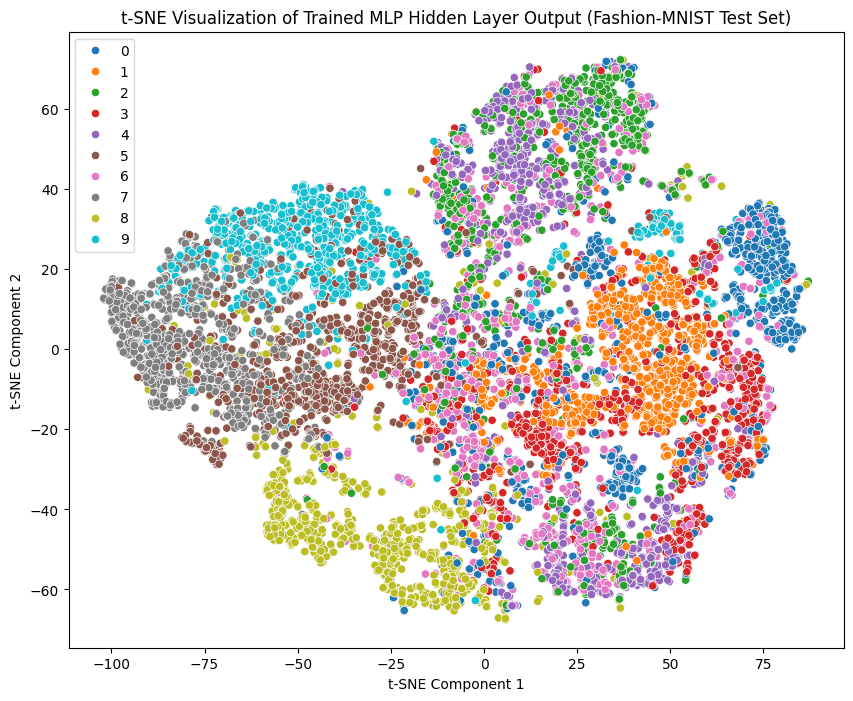

In [15]:

with torch.no_grad():
    fashion_hidden_layer_output_trained = torch.relu(model.hidden2(torch.relu(model.hidden1(fashion_X_test_t))))

fashion_hidden_layer_output_trained = fashion_hidden_layer_output_trained.cpu().numpy()
tsne_fashion = TSNE(n_components=2, random_state=42)
fashion_hidden_layer_tsne_trained = tsne_fashion.fit_transform(fashion_hidden_layer_output_trained)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=fashion_hidden_layer_tsne_trained[:, 0], y=fashion_hidden_layer_tsne_trained[:, 1], hue=fashion_y_test, palette='tab10', legend='full')
plt.title('t-SNE Visualization of Trained MLP Hidden Layer Output (Fashion-MNIST Test Set)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()